### Importing necessary libraries

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import models, layers
from tensorflow.keras.applications.resnet50 import preprocess_input

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### dataset link
breast cancer data : https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset

In [ ]:
train_dir = "/content/drive/MyDrive/ultrasound breast classification/train"

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # resize all images
    batch_size=32
)
print(train_dataset.class_names)


val_dir = "/content/drive/MyDrive/ultrasound breast classification/val"

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),  # resize all images
    batch_size=32
)

# See the class names
print(val_dataset.class_names)

Found 8127 files belonging to 2 classes.
['benign', 'malignant']
Found 903 files belonging to 2 classes.
['benign', 'malignant']


In [ ]:
# Load pretrained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

Classes: ['benign', 'malignant']


In [ ]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,803,330 (94.62 MB)

 Trainable params: 1,214,594 (4.63 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1826s 7s/step - accuracy: 0.7837 - loss: 0.4902 - val_accuracy: 0.8605 - val_loss: 0.3382
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1757s 7s/step - accuracy: 0.9081 - loss: 0.2377 - val_accuracy: 0.8627 - val_loss: 0.3004
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.9273 - loss: 0.1831 - val_accuracy: 0.7785 - val_loss: 0.5519
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1767s 7s/step - accuracy: 0.9450 - loss: 0.1380 - val_accuracy: 0.8339 - val_loss: 0.3928
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1789s 7s/step - accuracy: 0.9508 - loss: 0.1224 - val_accuracy: 0.9103 - val_loss: 0.2307
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1739s 7s/step - accuracy: 0.9573 - loss: 0.1110 - val_accuracy: 0.7796 - val_loss: 0.6698
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1735s 7s/step - accuracy: 0.9564 - loss: 0.1042 - val_accuracy: 0.8439 - val_loss: 0.5267
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1769s 7s/step - accuracy: 0.9660 - loss: 0.0857 - 

In [ ]:
# saving the model as keras
model.save("breast_cancer_resnet_model.keras")

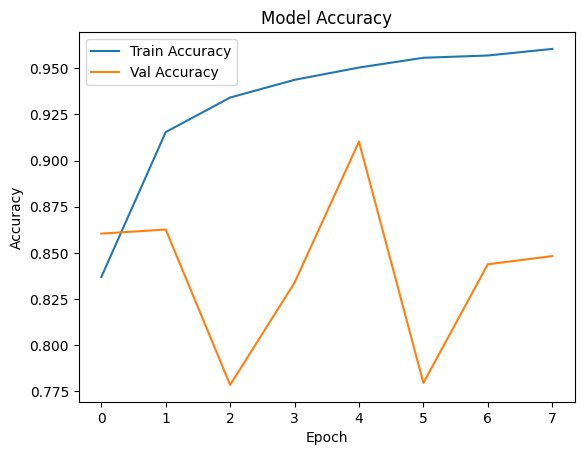

In [ ]:
# plotting the train acc and val acc vs epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

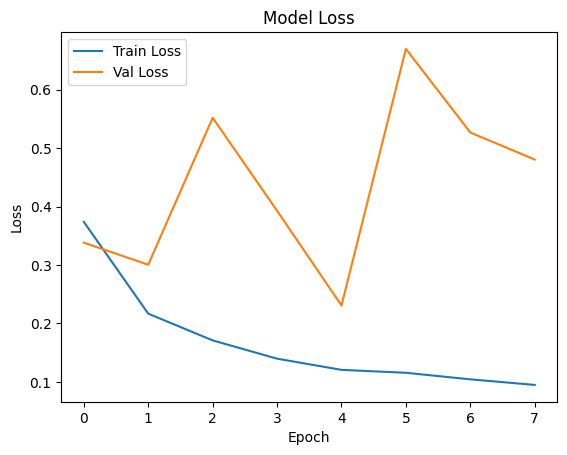

In [ ]:
# plotting the loss and val loss vs epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()